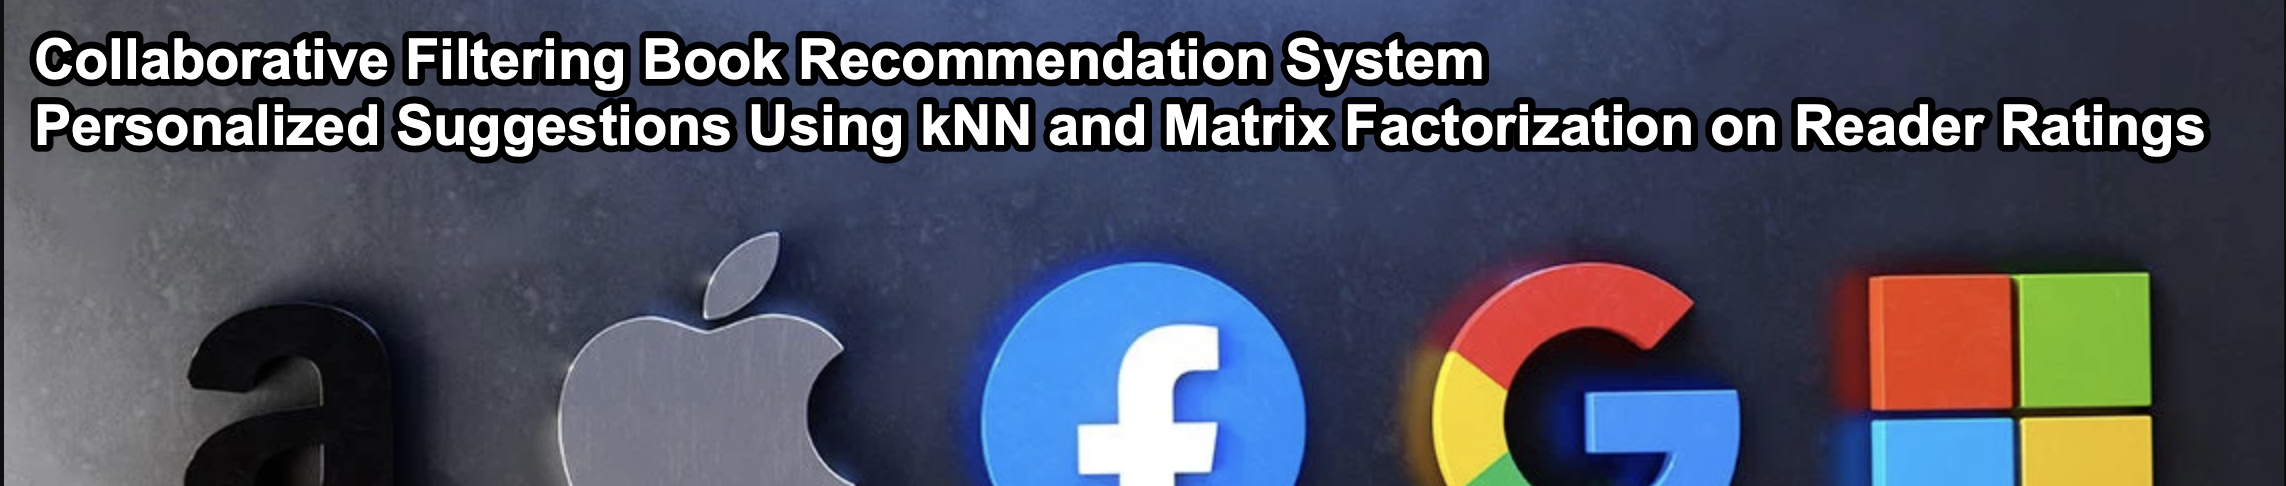

### 1. Import Libraries & Set-Up

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set display options for better readability
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
# Configure visualization style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 8)
%matplotlib inline

### 2. Load Data

In [5]:
# Define data folder
data_folder = 'recsys_assignment_data'

In [6]:
# Load datasets
ratings = pd.read_csv(os.path.join(data_folder, 'ratings.csv'))
books = pd.read_csv(os.path.join(data_folder, 'books.csv'))
to_read = pd.read_csv(os.path.join(data_folder, 'to_read.csv'))
book_tags = pd.read_csv(os.path.join(data_folder, 'book_tags.csv'))
tags = pd.read_csv(os.path.join(data_folder, 'tags.csv'))

### 3. EDA

#### 3.1 Ratings
Contains user ratings for books. Used to analyze user preferences and item popularity.

In [9]:
ratings

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3
...,...,...,...
5976474,49925,510,5
5976475,49925,528,4
5976476,49925,722,4
5976477,49925,949,5


         user_id    book_id     rating
count 5976479.00 5976479.00 5976479.00
mean    26224.46    2006.48       3.92
std     15413.23    2468.50       0.99
min         1.00       1.00       1.00
25%     12813.00     198.00       3.00
50%     25938.00     885.00       4.00
75%     39509.00    2973.00       5.00
max     53424.00   10000.00       5.00


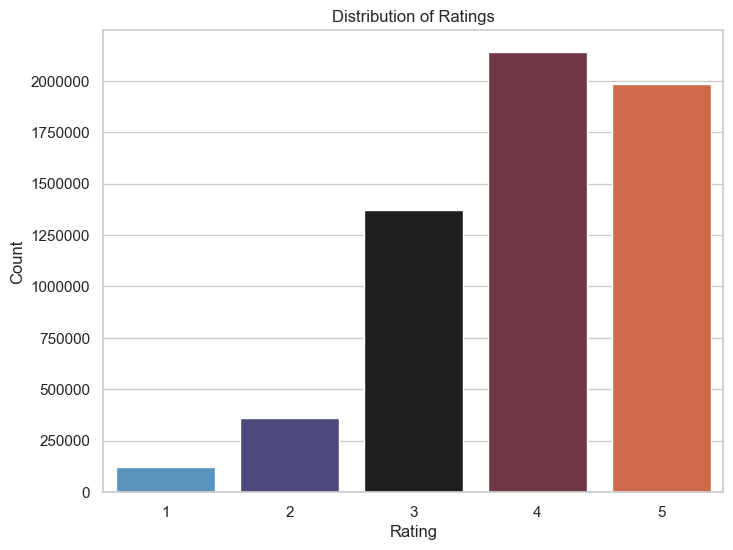

In [10]:
# Analyze the distribution of rating values (ratings range from 1 to 5)
rating_counts = ratings['rating'].value_counts().sort_index()

print(ratings.describe())
plt.figure(figsize=(8, 6))
sns.barplot(x=rating_counts.index, y=rating_counts.values, palette="icefire")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Distribution of Ratings")
plt.ticklabel_format(style='plain', axis='y')
plt.show()


User rating counts summary:
count   53424.00
mean      111.87
std        26.07
min        19.00
25%        96.00
50%       111.00
75%       128.00
max       200.00
dtype: float64


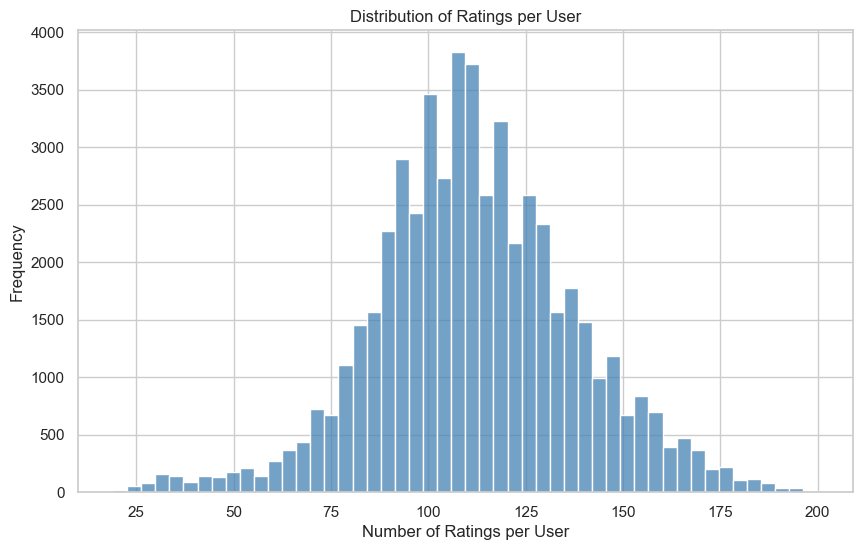

In [11]:
# %% [code]
# Analyze the number of ratings per user (user activity)
user_rating_counts = ratings.groupby('user_id').size()
print("\nUser rating counts summary:")
print(user_rating_counts.describe())

# Plot the distribution of ratings per user
plt.figure(figsize=(10, 6))
sns.histplot(user_rating_counts, bins=50, kde=False, color='steelblue')
plt.xlabel("Number of Ratings per User")
plt.ylabel("Frequency")
plt.title("Distribution of Ratings per User")
plt.show()


Book rating counts summary:
count   10000.00
mean      597.65
std      1267.29
min         8.00
25%       155.00
50%       248.00
75%       503.00
max     22806.00
dtype: float64


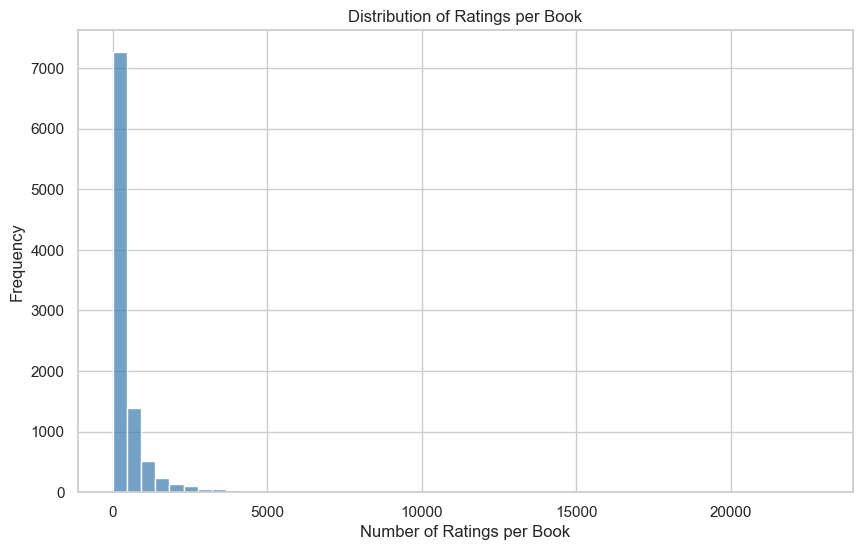

In [12]:
# %% [code]
# Analyze the number of ratings per user (user activity)
book_rating_counts = ratings.groupby('book_id').size()
print("\nBook rating counts summary:")
print(book_rating_counts.describe())

# Plot the distribution of ratings per user
plt.figure(figsize=(10, 6))
sns.histplot(book_rating_counts, bins=50, kde=False, color='steelblue')
plt.xlabel("Number of Ratings per Book")
plt.ylabel("Frequency")
plt.title("Distribution of Ratings per Book")
plt.show()

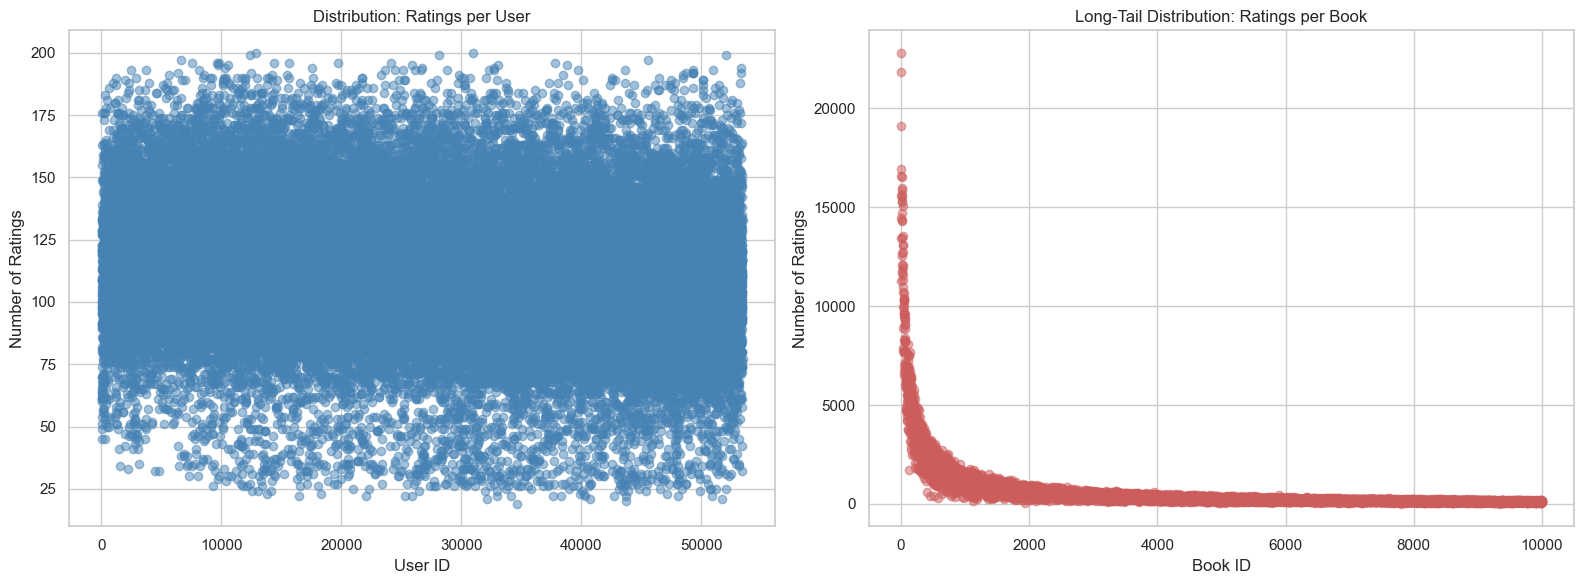

In [13]:
# Create regular plots
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Regular plot for user rating counts
ax[0].scatter(user_rating_counts.index, user_rating_counts.values, alpha=0.5, color='steelblue')
ax[0].set_xlabel("User ID")
ax[0].set_ylabel("Number of Ratings")
ax[0].set_title("Distribution: Ratings per User")

# Regular plot for book rating counts
ax[1].scatter(book_rating_counts.index, book_rating_counts.values, alpha=0.5, color='indianred')
ax[1].set_xlabel("Book ID")
ax[1].set_ylabel("Number of Ratings")
ax[1].set_title("Long-Tail Distribution: Ratings per Book")

plt.tight_layout()
plt.show()

#### 3.2 Books
Contains metadata about books. Essential for filtering and recommending books based on attributes.

In [15]:
books

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9780439023480.00,Suzanne Collins,2008.00,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9780439554930.00,"J.K. Rowling, Mary GrandPré",1997.00,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9780316015840.00,Stephenie Meyer,2005.00,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9780061120080.00,Harper Lee,1960.00,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9780743273560.00,F. Scott Fitzgerald,1925.00,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,7130616,7130616,7392860,19,441019455,9780441019460.00,Ilona Andrews,2010.00,Bayou Moon,...,17204,18856,1180,105,575,3538,7860,6778,https://images.gr-assets.com/books/1307445460m...,https://images.gr-assets.com/books/1307445460s...
9996,9997,208324,208324,1084709,19,067973371X,9780679733710.00,Robert A. Caro,1990.00,Means of Ascent,...,12582,12952,395,303,551,1737,3389,6972,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
9997,9998,77431,77431,2393986,60,039330762X,9780393307630.00,Patrick O'Brian,1977.00,The Mauritius Command,...,9421,10733,374,11,111,1191,4240,5180,https://images.gr-assets.com/books/1455373531m...,https://images.gr-assets.com/books/1455373531s...
9998,9999,8565083,8565083,13433613,7,61711527,9780061711530.00,Peggy Orenstein,2011.00,Cinderella Ate My Daughter: Dispatches from th...,...,11279,11994,1988,275,1002,3765,4577,2375,https://images.gr-assets.com/books/1279214118m...,https://images.gr-assets.com/books/1279214118s...


In [16]:
books.describe()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn13,original_publication_year,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5
count,10000.00,10000.00,10000.00,10000.00,10000.00,9415.00,9979.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00
mean,5000.50,5264696.51,5471213.58,8646183.42,75.71,9755044298883.46,1981.99,4.00,54001.24,59687.32,2919.96,1345.04,3110.89,11475.89,19965.70,23789.81
std,2886.90,7575461.86,7827329.89,11751060.82,170.47,442861920665.57,152.58,0.25,157369.96,167803.79,6124.38,6635.63,9717.12,28546.45,51447.36,79768.89
min,1.00,1.00,1.00,87.00,1.00,195170342.00,-1750.00,2.47,2716.00,5510.00,3.00,11.00,30.00,323.00,750.00,754.00
25%,2500.75,46275.75,47911.75,1008841.00,23.00,9780316192995.00,1990.00,3.85,13568.75,15438.75,694.00,196.00,656.00,3112.00,5405.75,5334.00
50%,5000.50,394965.50,425123.50,2719524.50,40.00,9780451528640.00,2004.00,4.02,21155.50,23832.50,1402.00,391.00,1163.00,4894.00,8269.50,8836.00
75%,7500.25,9382225.25,9636112.50,14517748.25,67.00,9780830777175.00,2011.00,4.18,41053.50,45915.00,2744.25,885.00,2353.25,9287.00,16023.50,17304.50
max,10000.00,33288638.00,35534230.00,56399597.00,3455.00,9790007672390.00,2017.00,4.82,4780653.00,4942365.00,155254.00,456191.00,436802.00,793319.00,1481305.00,3011543.00


In [17]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   book_id                    10000 non-null  int64  
 1   goodreads_book_id          10000 non-null  int64  
 2   best_book_id               10000 non-null  int64  
 3   work_id                    10000 non-null  int64  
 4   books_count                10000 non-null  int64  
 5   isbn                       9300 non-null   object 
 6   isbn13                     9415 non-null   float64
 7   authors                    10000 non-null  object 
 8   original_publication_year  9979 non-null   float64
 9   original_title             9415 non-null   object 
 10  title                      10000 non-null  object 
 11  language_code              8916 non-null   object 
 12  average_rating             10000 non-null  float64
 13  ratings_count              10000 non-null  int6

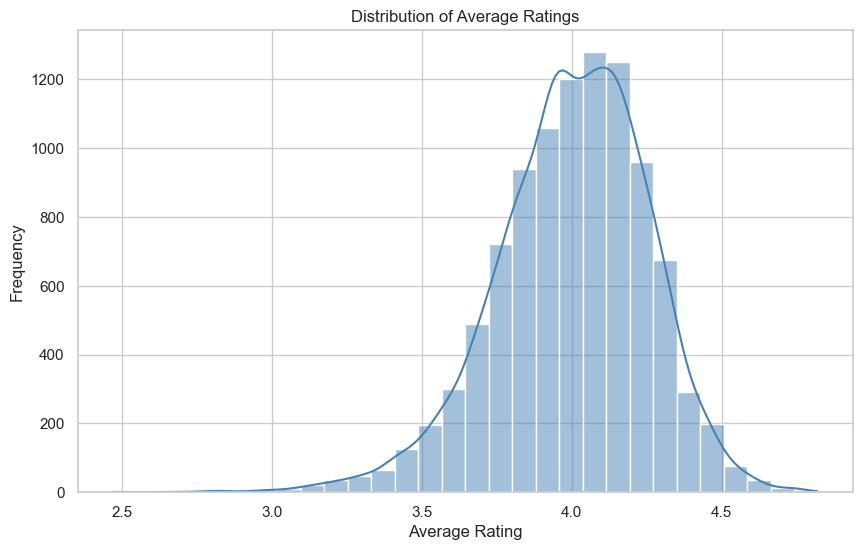

In [18]:
# Distribution of Average Ratings
plt.figure(figsize=(10, 6))
sns.histplot(books['average_rating'], bins=30, kde=True, color='steelblue')
plt.xlabel("Average Rating")
plt.ylabel("Frequency")
plt.title("Distribution of Average Ratings")
plt.show()

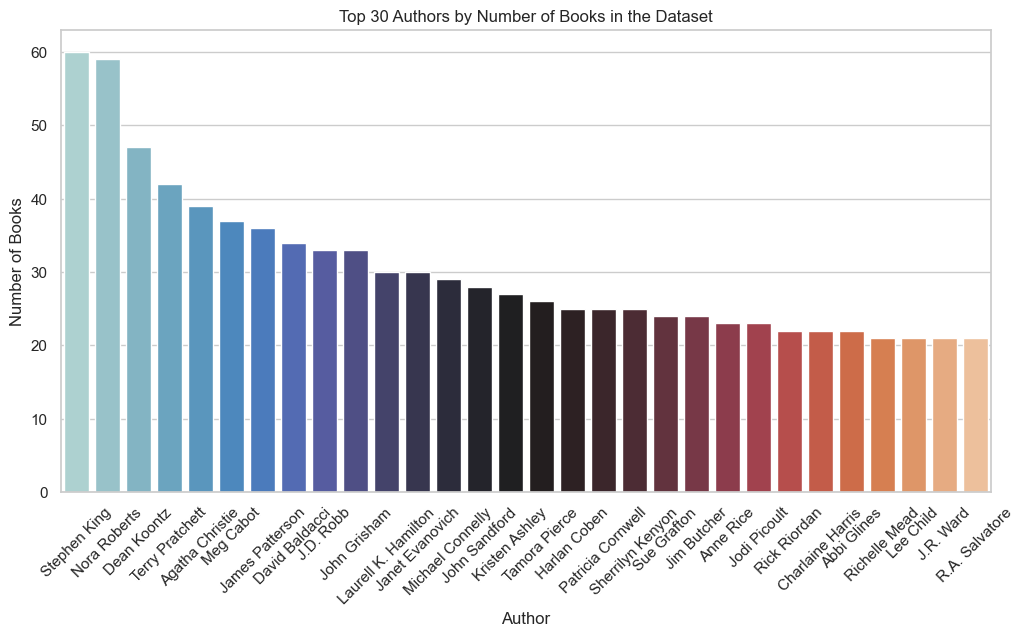

In [19]:
# Top Authors by number of books
top_authors = books['authors'].value_counts().head(30)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_authors.index, y=top_authors.values, palette="icefire")
plt.xlabel("Author")
plt.ylabel("Number of Books")
plt.title("Top 30 Authors by Number of Books in the Dataset")
plt.xticks(rotation=45)
plt.show()

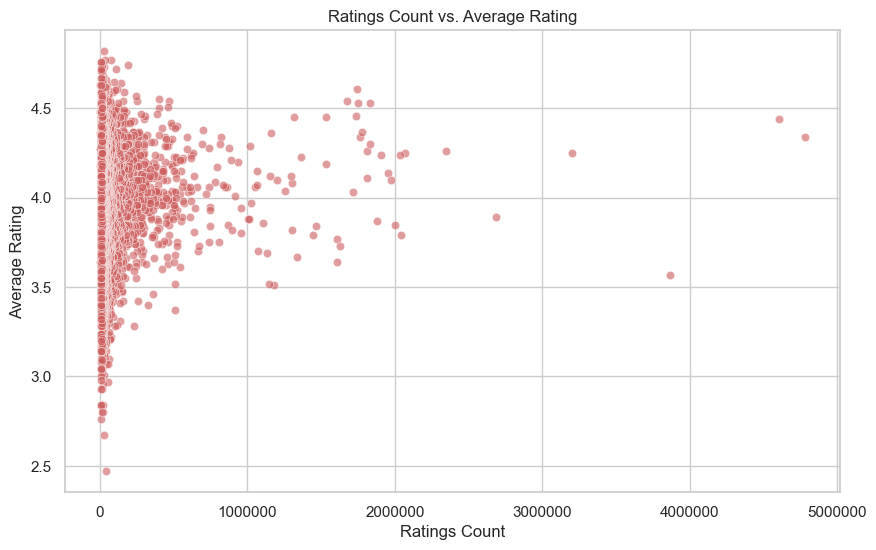

In [20]:
# Scatter plot: Ratings Count vs. Average Rating 
plt.figure(figsize=(10, 6))
sns.scatterplot(data=books, x='ratings_count', y='average_rating', alpha=0.6, color='indianred')
plt.xlabel("Ratings Count")
plt.ylabel("Average Rating") 
plt.title("Ratings Count vs. Average Rating")
plt.ticklabel_format(axis='x', style='plain')
plt.show()

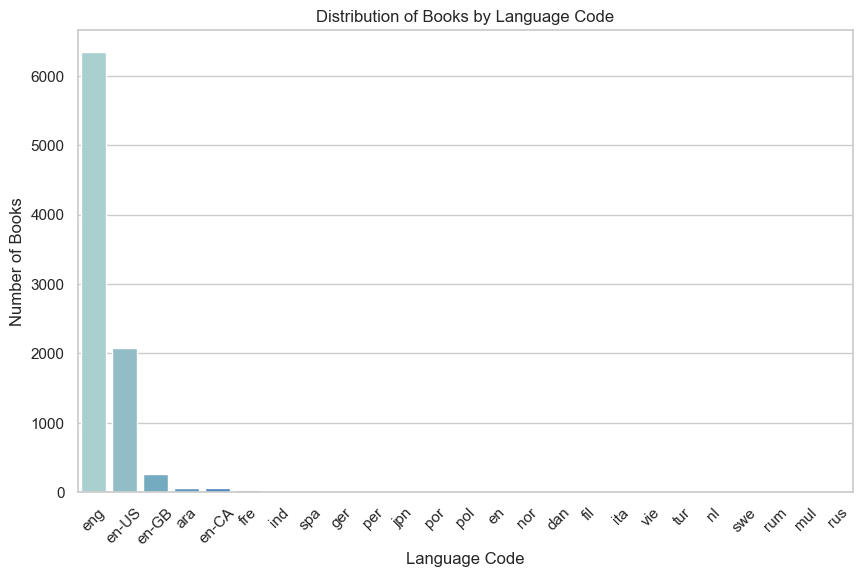

In [21]:
# Count of Books by Language
plt.figure(figsize=(10, 6))
language_counts = books['language_code'].value_counts()
sns.barplot(x=language_counts.index, y=language_counts.values, palette="icefire")
plt.xlabel("Language Code")
plt.ylabel("Number of Books")
plt.title("Distribution of Books by Language Code")
plt.xticks(rotation=45)
plt.show()

In [22]:
# Books with highest average rating (at least 100 ratings for reliability)
top_books = books[books['ratings_count'] > 100].sort_values(by='average_rating', ascending=False).head(10)
print("\nTop 10 Highest Rated Books:")
top_books[['title', 'authors', 'average_rating', 'ratings_count']]


Top 10 Highest Rated Books:


,title,authors,average_rating,ratings_count
3627,The Complete Calvin and Hobbes,Bill Watterson,4.82,28900
3274,"Harry Potter Boxed Set, Books 1-5 (Harry Potte...","J.K. Rowling, Mary GrandPré",4.77,33220
861,"Words of Radiance (The Stormlight Archive, #2)",Brandon Sanderson,4.77,73572
8853,Mark of the Lion Trilogy,Francine Rivers,4.76,9081
7946,ESV Study Bible,"Anonymous, Lane T. Dennis, Wayne A. Grudem",4.76,8953
4482,It's a Magical World: A Calvin and Hobbes Coll...,Bill Watterson,4.75,22351
6360,There's Treasure Everywhere: A Calvin and Hobb...,Bill Watterson,4.74,16766
421,"Harry Potter Boxset (Harry Potter, #1-7)",J.K. Rowling,4.74,190050
3752,"Harry Potter Collection (Harry Potter, #1-6)",J.K. Rowling,4.73,24618
6919,The Indispensable Calvin and Hobbes,Bill Watterson,4.73,14597


In [23]:
# Most rated books
most_rated_books = books.sort_values(by='ratings_count', ascending=False).head(10)
most_rated_books[['title', 'authors', 'average_rating', 'ratings_count']]

,title,authors,average_rating,ratings_count
0,"The Hunger Games (The Hunger Games, #1)",Suzanne Collins,4.34,4780653
1,Harry Potter and the Sorcerer's Stone (Harry P...,"J.K. Rowling, Mary GrandPré",4.44,4602479
2,"Twilight (Twilight, #1)",Stephenie Meyer,3.57,3866839
3,To Kill a Mockingbird,Harper Lee,4.25,3198671
4,The Great Gatsby,F. Scott Fitzgerald,3.89,2683664
5,The Fault in Our Stars,John Green,4.26,2346404
6,The Hobbit,J.R.R. Tolkien,4.25,2071616
7,The Catcher in the Rye,J.D. Salinger,3.79,2044241
9,Pride and Prejudice,Jane Austen,4.24,2035490
8,"Angels & Demons (Robert Langdon, #1)",Dan Brown,3.85,2001311


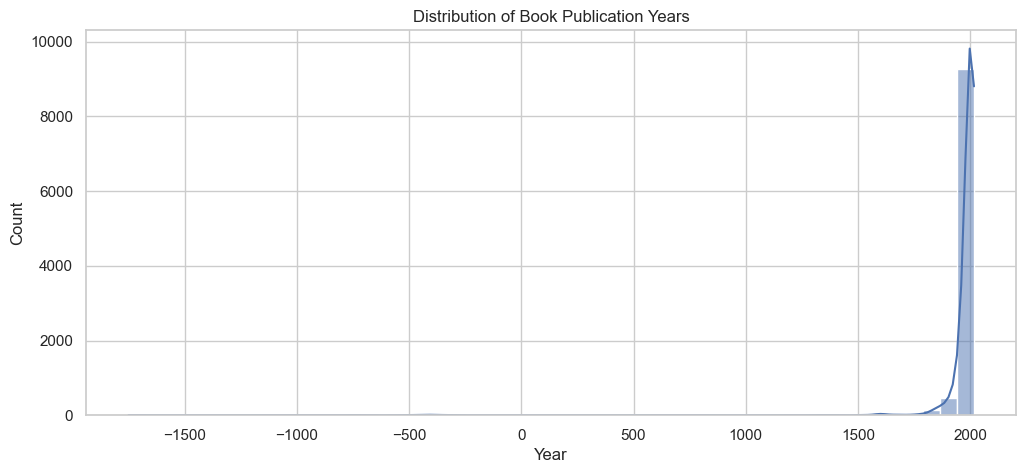

In [24]:
# Publication year analysis
plt.figure(figsize=(12, 5))
sns.histplot(books['original_publication_year'], bins=50, kde=True ,palette="icefire")
plt.title('Distribution of Book Publication Years')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

#### 3.3 To Read
Lists books that users have marked as "to-read." Helpful for understanding user intent beyond explicit ratings.

In [26]:
to_read

,user_id,book_id
0,9,8
1,15,398
2,15,275
3,37,7173
4,34,380
...,...,...
912700,39374,1049
912701,10492,5180
912702,21879,4827
912703,21879,6642


Summary statistics for 'to read' counts per user:
count   48871.00
mean       18.68
std        16.09
min         1.00
25%         6.00
50%        14.00
75%        27.00
max       117.00
dtype: float64


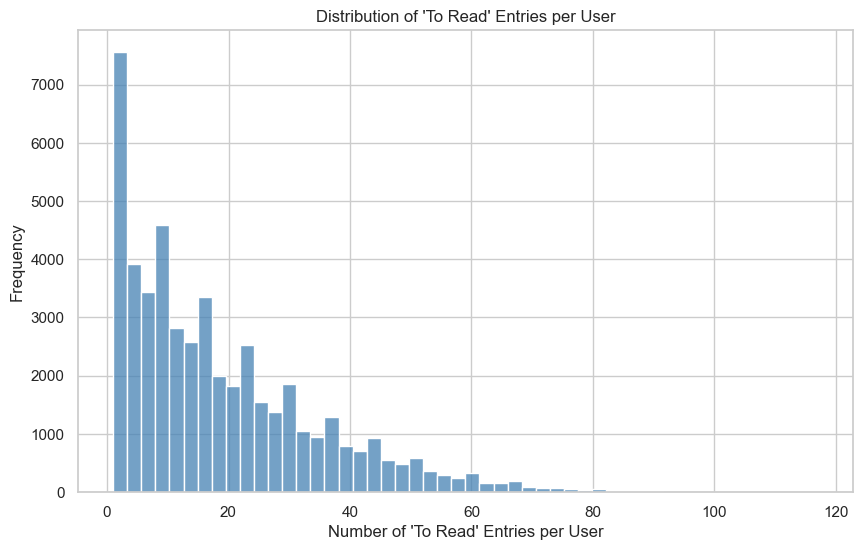

In [27]:
# Distribution of "To Read" entries per User
user_to_read_counts = to_read.groupby('user_id').size()
print("Summary statistics for 'to read' counts per user:")
print(user_to_read_counts.describe())

plt.figure(figsize=(10, 6))
sns.histplot(user_to_read_counts, bins=50, color='steelblue')  # Removed log_scale
plt.xlabel("Number of 'To Read' Entries per User")  # Removed log scale mention
plt.ylabel("Frequency")
plt.title("Distribution of 'To Read' Entries per User")
plt.ticklabel_format(style='plain')  # Disable scientific notation
plt.show()

Summary statistics for 'to read' counts per book:
count   9986.00
mean      91.40
std      160.56
min        1.00
25%       20.00
50%       42.00
75%       90.00
max     2772.00
dtype: float64


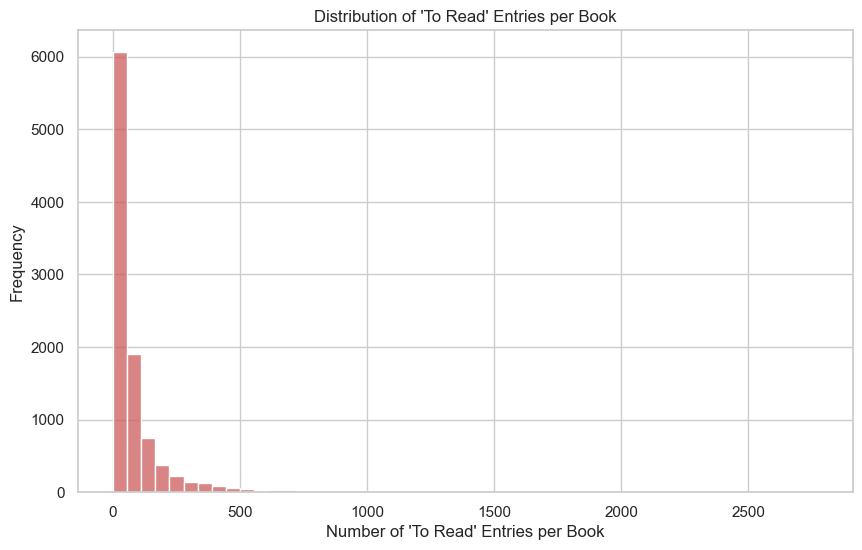

In [28]:
# Distribution of "To Read" entries per Book
book_to_read_counts = to_read.groupby('book_id').size()
print("Summary statistics for 'to read' counts per book:")
print(book_to_read_counts.describe())

plt.figure(figsize=(10, 6))
sns.histplot(book_to_read_counts, bins=50, color='indianred')  # Removed log_scale
plt.xlabel("Number of 'To Read' Entries per Book")  # Removed log scale mention
plt.ylabel("Frequency")
plt.title("Distribution of 'To Read' Entries per Book")
plt.ticklabel_format(style='plain')  # Disable scientific notation
plt.show()

#### 3.4 Book Tags
Maps books to various tags assigned by users. Helps in content-based recommendations based on tags.

In [30]:
# Merge books with book_tags to get metadata with tags
merged_book_tags = book_tags.merge(tags, on='tag_id', how='left')
merged_book_tags

,goodreads_book_id,tag_id,count,tag_name
0,1,30574,167697,to-read
1,1,11305,37174,fantasy
2,1,11557,34173,favorites
3,1,8717,12986,currently-reading
4,1,33114,12716,young-adult
...,...,...,...,...
999907,33288638,21303,7,neighbors
999908,33288638,17271,7,kindleunlimited
999909,33288638,1126,7,5-star-reads
999910,33288638,11478,7,fave-author


In [31]:
# Display basic info about the merged dataframe - Tag per Book
print("Shape of merged book tags data:", merged_book_tags.shape)
merged_book_tags.describe()

Shape of merged book tags data: (999912, 4)


,goodreads_book_id,tag_id,count
count,999912.00,999912.00,999912.00
mean,5263441.95,16324.53,208.87
std,7574057.10,9647.85,3501.27
min,1.00,0.00,-1.00
25%,46227.00,8067.00,7.00
50%,394841.00,15808.00,15.00
75%,9378297.00,24997.00,40.00
max,33288638.00,34251.00,596234.00


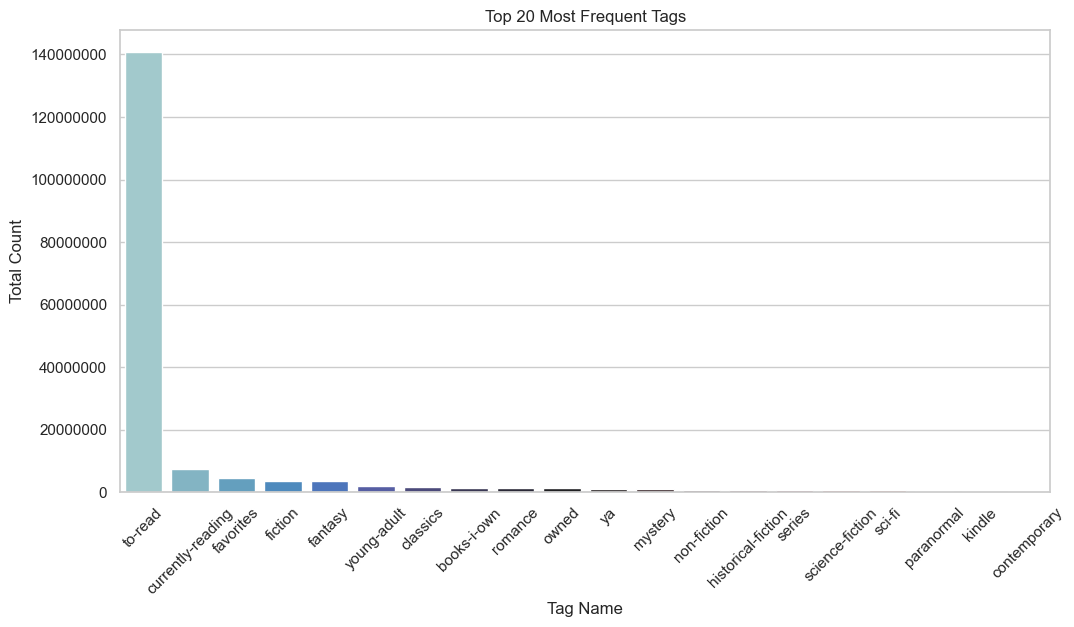

In [32]:
# Analyze the aggregated tag frequency
tag_frequency = merged_book_tags.groupby('tag_name')['count'].sum().reset_index().sort_values(by='count', ascending=False)

# Bar plot for top 10 most frequent tags
plt.figure(figsize=(12, 6))
sns.barplot(x='tag_name', y='count', data=tag_frequency.head(20), palette="icefire")
plt.xlabel("Tag Name")
plt.ylabel("Total Count")
plt.title("Top 20 Most Frequent Tags")
plt.xticks(rotation=45)
plt.ticklabel_format(axis='y', style='plain')  # This is the standard way
plt.show()

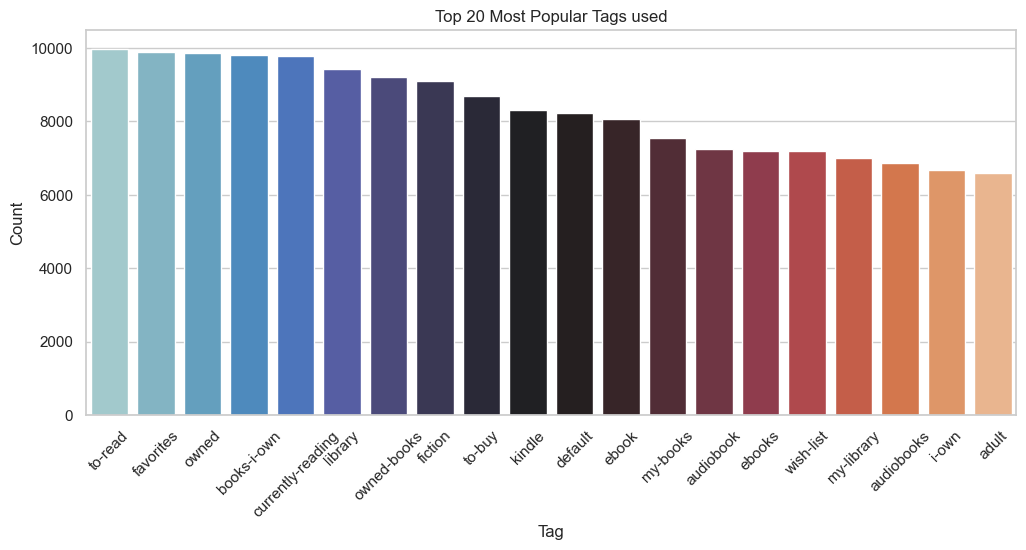

In [33]:
# Most popular tags
top_tags = merged_book_tags['tag_name'].value_counts().head(20)
plt.figure(figsize=(12, 5))
sns.barplot(x=top_tags.index, y=top_tags.values, palette='icefire')
plt.xticks(rotation=45)
plt.title('Top 20 Most Popular Tags used')
plt.xlabel('Tag')
plt.ylabel('Count')
plt.show()

In [34]:
# Determine the number of tags per book
tags_per_book = merged_book_tags.groupby('goodreads_book_id').size()
print("Summary of number of tags per book:")
tags_per_book.describe()

Summary of number of tags per book:


count   10000.00
mean       99.99
std         0.58
min        56.00
25%       100.00
50%       100.00
75%       100.00
max       100.00
dtype: float64

### 4. Data Preperation

In [36]:
books

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9780439023480.00,Suzanne Collins,2008.00,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9780439554930.00,"J.K. Rowling, Mary GrandPré",1997.00,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9780316015840.00,Stephenie Meyer,2005.00,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9780061120080.00,Harper Lee,1960.00,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9780743273560.00,F. Scott Fitzgerald,1925.00,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,7130616,7130616,7392860,19,441019455,9780441019460.00,Ilona Andrews,2010.00,Bayou Moon,...,17204,18856,1180,105,575,3538,7860,6778,https://images.gr-assets.com/books/1307445460m...,https://images.gr-assets.com/books/1307445460s...
9996,9997,208324,208324,1084709,19,067973371X,9780679733710.00,Robert A. Caro,1990.00,Means of Ascent,...,12582,12952,395,303,551,1737,3389,6972,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
9997,9998,77431,77431,2393986,60,039330762X,9780393307630.00,Patrick O'Brian,1977.00,The Mauritius Command,...,9421,10733,374,11,111,1191,4240,5180,https://images.gr-assets.com/books/1455373531m...,https://images.gr-assets.com/books/1455373531s...
9998,9999,8565083,8565083,13433613,7,61711527,9780061711530.00,Peggy Orenstein,2011.00,Cinderella Ate My Daughter: Dispatches from th...,...,11279,11994,1988,275,1002,3765,4577,2375,https://images.gr-assets.com/books/1279214118m...,https://images.gr-assets.com/books/1279214118s...


In [37]:
print("\nBooks DataFrame Info:")
print(books.info())


Books DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   book_id                    10000 non-null  int64  
 1   goodreads_book_id          10000 non-null  int64  
 2   best_book_id               10000 non-null  int64  
 3   work_id                    10000 non-null  int64  
 4   books_count                10000 non-null  int64  
 5   isbn                       9300 non-null   object 
 6   isbn13                     9415 non-null   float64
 7   authors                    10000 non-null  object 
 8   original_publication_year  9979 non-null   float64
 9   original_title             9415 non-null   object 
 10  title                      10000 non-null  object 
 11  language_code              8916 non-null   object 
 12  average_rating             10000 non-null  float64
 13  ratings_count           

In [38]:
books = books[['book_id', 'work_id', 'title', 'authors', 'average_rating', 'ratings_count']].copy()
print("Books relevant (after cleaning):", books.shape)

Books relevant (after cleaning): (10000, 6)


In [39]:
print("Missing values in books:")
print(books.isnull().sum())

Missing values in books:
book_id           0
work_id           0
title             0
authors           0
average_rating    0
ratings_count     0
dtype: int64


#### 5. Grid Search: Optimal Hyperparameters for Collaborative Filtering (Matrix Factorization)

In [46]:
from sklearn.model_selection import train_test_split

def evaluate_thresholds(ratings, min_user, min_book, k=50, test_size=0.2, random_state=42):
    """
    Evaluate a matrix factorization (SVD-based) model using specified filtering thresholds.
    
    Parameters:
        ratings (DataFrame): The original ratings DataFrame.
        min_user (int): Minimum number of ratings per user.
        min_book (int): Minimum number of ratings per book.
        k (int): Number of latent factors to keep in the truncated SVD.
        test_size (float): Proportion of data to use as the test set.
        random_state (int): Random seed for reproducibility.
    
    Returns:
        rmse (float): RMSE on the test set predictions.
        n_users (int): Number of users in the filtered training matrix.
        n_books (int): Number of books in the filtered training matrix.
    """
    # --- Filter the ratings based on the provided thresholds ---
    user_counts = ratings['user_id'].value_counts()
    book_counts = ratings['book_id'].value_counts()
    
    valid_users = user_counts[user_counts >= min_user].index
    valid_books = book_counts[book_counts >= min_book].index
    
    ratings_filtered = ratings[ratings['user_id'].isin(valid_users) & ratings['book_id'].isin(valid_books)]
    
    # If filtering results in an empty DataFrame, return an infinite error.
    if ratings_filtered.empty:
        return np.inf, 0, 0
    
    # --- Split the filtered data into training and testing sets ---
    train_ratings, test_ratings = train_test_split(ratings_filtered, test_size=test_size, random_state=random_state)
    
    # --- Build the user-book sparse matrix for training ---
    train_matrix = train_ratings.pivot_table(index='user_id', columns='book_id', values='rating', aggfunc='mean').fillna(0)
    sparse_train = csr_matrix(train_matrix.values)
    
    # --- Perform truncated SVD on the training matrix ---
    try:
        U, sigma, Vt = svds(sparse_train, k=k)
        sigma = np.diag(sigma)
        R_pred = np.dot(np.dot(U, sigma), Vt)
    except Exception as e:
        print(f"SVD failed for min_user={min_user}, min_book={min_book} with error: {e}")
        return np.inf, train_matrix.shape[0], train_matrix.shape[1]
    
    # --- Create mappings from user_id and book_id to matrix indices ---
    user_index = {user: idx for idx, user in enumerate(train_matrix.index)}
    book_index = {book: idx for idx, book in enumerate(train_matrix.columns)}
    
    # --- Evaluate RMSE on the test set (using vectorized computation) ---
    test_ratings = test_ratings[test_ratings['user_id'].isin(user_index) & test_ratings['book_id'].isin(book_index)]
    
    if test_ratings.empty:
        return np.inf, train_matrix.shape[0], train_matrix.shape[1]
    
    # Vectorized computation of RMSE
    user_idx = test_ratings['user_id'].map(user_index)
    book_idx = test_ratings['book_id'].map(book_index)
    true_ratings = test_ratings['rating'].values
    
    pred_ratings = R_pred[user_idx, book_idx]
    squared_errors = (true_ratings - pred_ratings) ** 2
    rmse = np.sqrt(np.mean(squared_errors))
    
    return rmse, train_matrix.shape[0], train_matrix.shape[1]

In [72]:
# --- Define a grid of threshold values to explore ---
user_thresholds = [0, 10, 20, 50, 100, 200, 50]
book_thresholds = [0, 10, 20, 50, 100, 200]

results = []

for min_user in user_thresholds:
    for min_book in book_thresholds:
        rmse, n_users, n_books = evaluate_thresholds(ratings, min_user, min_book, k=50)
        results.append({
            'min_user_ratings': min_user,
            'min_book_ratings': min_book,
            'rmse': rmse,
            'n_users': n_users,
            'n_books': n_books
        })
        print(f"min_user: {min_user}, min_book: {min_book} => RMSE: {rmse:.4f}, Users: {n_users}, Books: {n_books}")

min_user: 0, min_book: 0 => RMSE: 3.4731, Users: 53424, Books: 10000
min_user: 0, min_book: 10 => RMSE: 3.4726, Users: 53424, Books: 9999
min_user: 0, min_book: 20 => RMSE: 3.4728, Users: 53424, Books: 9998
min_user: 0, min_book: 50 => RMSE: 3.4705, Users: 53424, Books: 9991
min_user: 0, min_book: 100 => RMSE: 3.4661, Users: 53424, Books: 9511
min_user: 0, min_book: 200 => RMSE: 3.4220, Users: 53424, Books: 6101
min_user: 0, min_book: 500 => RMSE: 3.3207, Users: 53423, Books: 2526
min_user: 10, min_book: 0 => RMSE: 3.4731, Users: 53424, Books: 10000
min_user: 10, min_book: 10 => RMSE: 3.4726, Users: 53424, Books: 9999
min_user: 10, min_book: 20 => RMSE: 3.4728, Users: 53424, Books: 9998
min_user: 10, min_book: 50 => RMSE: 3.4705, Users: 53424, Books: 9991
min_user: 10, min_book: 100 => RMSE: 3.4661, Users: 53424, Books: 9511
min_user: 10, min_book: 200 => RMSE: 3.4220, Users: 53424, Books: 6101
min_user: 10, min_book: 500 => RMSE: 3.3207, Users: 53423, Books: 2526
min_user: 20, min_boo

In [74]:
# --- Define a grid of threshold values to explore ---
user_thresholds = [0, 10, 20, 50, 100, 200]
book_thresholds = [0, 10, 20, 50, 100, 200]

# Results list
results = []

# Calculate total number of combinations once
total_combinations = len(user_thresholds) * len(book_thresholds)

# Loop through all combinations using index tracking
for idx in range(total_combinations):
    min_user = user_thresholds[idx // len(book_thresholds)]  # Determine min_user based on index
    min_book = book_thresholds[idx % len(book_thresholds)]  # Determine min_book based on index
    
    rmse, n_users, n_books = evaluate_thresholds(ratings, min_user, min_book, k=50)
    results.append({
        'min_user_ratings': min_user,
        'min_book_ratings': min_book,
        'rmse': rmse,
        'n_users': n_users,
        'n_books': n_books
    })
    
    # Print progress
    print(f"min_user: {min_user}, min_book: {min_book} => RMSE: {rmse:.4f}, Users: {n_users}, Books: {n_books}")

min_user: 0, min_book: 0 => RMSE: 3.4731, Users: 53424, Books: 10000
min_user: 0, min_book: 10 => RMSE: 3.4726, Users: 53424, Books: 9999
min_user: 0, min_book: 20 => RMSE: 3.4728, Users: 53424, Books: 9998
min_user: 0, min_book: 50 => RMSE: 3.4705, Users: 53424, Books: 9991
min_user: 0, min_book: 100 => RMSE: 3.4661, Users: 53424, Books: 9511
min_user: 0, min_book: 200 => RMSE: 3.4220, Users: 53424, Books: 6101
min_user: 10, min_book: 0 => RMSE: 3.4731, Users: 53424, Books: 10000
min_user: 10, min_book: 10 => RMSE: 3.4726, Users: 53424, Books: 9999
min_user: 10, min_book: 20 => RMSE: 3.4728, Users: 53424, Books: 9998
min_user: 10, min_book: 50 => RMSE: 3.4705, Users: 53424, Books: 9991
min_user: 10, min_book: 100 => RMSE: 3.4661, Users: 53424, Books: 9511
min_user: 10, min_book: 200 => RMSE: 3.4220, Users: 53424, Books: 6101
min_user: 20, min_book: 0 => RMSE: 3.4730, Users: 53423, Books: 10000
min_user: 20, min_book: 10 => RMSE: 3.4734, Users: 53423, Books: 9999
min_user: 20, min_book

After grid search, we found that **min_user = 50** and **min_book = 100** offer the best balance between model accuracy and data retention.

**1. RMSE and Data Retention**:
- RMSE is 3.4652, which indicates a good model fit.
- We retain **52,525 users** and **9,490 books**, providing a robust dataset for recommendations.

**2. Why Not Higher Thresholds?**:
- Higher thresholds (e.g., min_user = 100) improve RMSE marginally but result in substantial data loss, making the model sparse and unreliable.

**3. Trade-off**:
- This setting offers a solid trade-off between accuracy and data size, ensuring effective recommendations without overfitting.

In [90]:
# Compress the matrix by filtering out very inactive users and rarely rated books.
min_user_ratings = 50  # only keep users who have rated at least 50 books
min_book_ratings = 100  # only keep books that have at least 100 ratings

### 6. Collaborative Filtering

#### 6.1 Count Ratings

In [70]:
print(user_rating_counts)
print("")
print(book_rating_counts)

user_id
1        117
2         65
3         91
4        134
5        100
        ... 
53420    110
53421    110
53422    130
53423     77
53424    133
Length: 53424, dtype: int64

book_id
1        22806
2        21850
3        16931
4        19088
5        16604
         ...  
9996       141
9997        93
9998       102
9999       130
10000      111
Length: 10000, dtype: int64


#### 6.2 Matrix Compression

In [75]:
def filter_ratings(ratings, min_user_ratings, min_book_ratings):

    # Identify valid users and books based on the thresholds
    valid_users = user_rating_counts[user_rating_counts >= min_user_ratings].index
    valid_books = book_rating_counts[book_rating_counts >= min_book_ratings].index

    # Filter the ratings DataFrame
    filtered_ratings = ratings[
        (ratings.user_id.isin(valid_users)) & (ratings.book_id.isin(valid_books))
    ].copy()

    print("Original ratings shape:", ratings.shape)
    print("Filtered ratings shape:", filtered_ratings.shape)

    return filtered_ratings

In [77]:
ratings = filter_ratings(ratings, min_user_ratings, min_book_ratings)

Original ratings shape: (5976479, 3)
Filtered ratings shape: (4598238, 3)


#### 6.3 User-Based Collaborative Filtering

In [80]:
# For collaborative filtering with KNN, we need a complete matrix.
# A common practice is to fill missing entries with 0.
# (Note: Using 0 implies “no rating” and has implications when computing similarity.)
user_book_matrix = ratings.pivot(index='user_id', columns='book_id', values='rating')
user_book_matrix = user_book_matrix.fillna(0)
user_book_matrix

book_id,1,2,3,4,5,6,7,8,9,10,...,9988,9990,9991,9992,9994,9995,9996,9998,9999,10000
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.00,0.00,0.00,5.00,0.00,0.00,0.00,0.00,0.00,4.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,5.00,0.00,4.00,4.00,0.00,4.00,4.00,0.00,5.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,4.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,3.00,0.00,0.00,2.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,4.00,4.00,4.00,0.00,5.00,0.00,0.00,0.00,1.00,5.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53419,4.00,5.00,3.00,3.00,3.00,5.00,0.00,3.00,5.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
53420,4.00,5.00,3.00,0.00,2.00,0.00,0.00,0.00,4.00,3.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
53421,4.00,5.00,0.00,5.00,4.00,0.00,4.00,0.00,5.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [81]:
sparse_user_book = csr_matrix(user_book_matrix.values)
sparse_user_book

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 4598238 stored elements and shape (37084, 9495)>

In [82]:
# Using the user-book matrix, we build a KNN model to find similar users.
model_user = NearestNeighbors(metric='cosine', algorithm='brute')
model_user.fit(sparse_user_book)

NearestNeighbors(algorithm='brute', metric='cosine')

In [83]:
def get_user_recommendations(user_id, model, user_book_df, books_df, n_neighbors=10, n_recommendations=5):
    """
    Given a target user_id, find n_neighbors similar users (excluding the user itself),
    then recommend books that those similar users have highly rated but the target user hasn't rated.
    
    Parameters:
        user_id (int): The ID of the target user.
        model: A fitted NearestNeighbors model on user vectors.
        user_book_df (DataFrame): The user-book rating matrix (with 0 for missing ratings).
        books_df (DataFrame): Books metadata DataFrame for title lookup.
        n_neighbors (int): Number of neighbors to consider (excluding self).
        n_recommendations (int): Number of book recommendations to return.
    
    Returns:
        List of tuples: Each tuple contains (book_id, title).
    """
    if user_id not in user_book_df.index:
        print(f"User {user_id} not found in the dataset.")
        return []
    
    # Get the row index for the target user.
    user_idx = user_book_df.index.get_loc(user_id)
    
    # Query for similar users; request n_neighbors+1 because the first neighbor is the user itself.
    distances, indices = model.kneighbors(
        user_book_df.iloc[user_idx, :].values.reshape(1, -1),
        n_neighbors=n_neighbors+1
    )
    
    # Exclude the target user and get the similar user IDs.
    similar_user_indices = indices.flatten()[1:]
    similar_user_ids = user_book_df.index[similar_user_indices]
    
    # Vectorized aggregation: Sum ratings from similar users (only consider positive ratings).
    similar_ratings = user_book_df.loc[similar_user_ids]
    candidate_scores = similar_ratings.where(similar_ratings > 0, 0).sum(axis=0)
    
    # Exclude books the target user has already rated.
    user_rated = user_book_df.loc[user_id] > 0
    candidate_scores = candidate_scores[~user_rated]
    
    # Get the top n recommendations by aggregated score.
    top_books = candidate_scores.sort_values(ascending=False).head(n_recommendations)
    
    # Look up book titles from books_df (assuming 'book_id' is the key and 'title' holds the title).
    recommendations = []
    for book_id, score in top_books.items():
        title_row = books_df.loc[books_df['book_id'] == book_id, 'title']
        title = title_row.iloc[0] if not title_row.empty else "Unknown Title"
        recommendations.append((book_id, title))
    
    return recommendations

In [84]:
test_user_id = user_book_matrix.index[0]
print("User-Based Recommendations for User ID:", test_user_id)
user_recs = get_user_recommendations(test_user_id, model_user, user_book_matrix, books, n_neighbors=10, n_recommendations=5)
for rec in user_recs:
    print(f"Book ID: {rec[0]}, Title: {rec[1]}")

User-Based Recommendations for User ID: 1
Book ID: 5, Title: The Great Gatsby
Book ID: 8, Title: The Catcher in the Rye
Book ID: 118, Title: The Joy Luck Club
Book ID: 15, Title: The Diary of a Young Girl
Book ID: 195, Title: The Guernsey Literary and Potato Peel Pie Society


In [85]:
from tqdm import tqdm
from joblib import Parallel, delayed

def generate_all_user_recommendations(model, user_book_df, books_df, n_neighbors=10, n_recommendations=5,
                                      export_path="user_recommendations.csv", n_jobs=-1):
    """
    Generates book recommendations for each user in parallel and exports the results to a CSV.
    
    Parameters:
        model: Fitted NearestNeighbors model for user-based collaborative filtering.
        user_book_df (pd.DataFrame): User-book rating matrix (with 0 for missing ratings).
        books_df (pd.DataFrame): Books metadata DataFrame for title lookup.
        n_neighbors (int): Number of neighbors to consider (excluding self).
        n_recommendations (int): Number of recommendations per user.
        export_path (str): File path for CSV export.
        n_jobs (int): Number of parallel jobs; -1 uses all available cores.
        
    Returns:
        pd.DataFrame: DataFrame containing recommendations for each user.
    """
    # Inner function to process a single user
    def process_user(user_id):
        # Get recommendations for the current user using the provided function.
        recs = get_user_recommendations(user_id, model, user_book_df, books_df, 
                                        n_neighbors=n_neighbors, n_recommendations=n_recommendations)
        # Create a list of recommendation records (one per recommended book).
        return [
            {"user_id": user_id, "recommendation_rank": rank, "book_id": book_id, "title": title}
            for rank, (book_id, title) in enumerate(recs, start=1)
        ]
    
    # Process all users in parallel using joblib. The tqdm wrapper provides a progress bar.
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_user)(user_id) for user_id in tqdm(user_book_df.index, desc="Generating recommendations")
    )
    
    # Flatten the list of lists into a single list of recommendation records.
    recommendations_list = [record for sublist in results for record in sublist]
    
    # Create a DataFrame, sort by user and recommendation rank, and export to CSV.
    recommendations_df = pd.DataFrame(recommendations_list)
    recommendations_df.sort_values(by=["user_id", "recommendation_rank"], inplace=True)
    recommendations_df.to_csv(export_path, index=False)
    
    print(f"Recommendations exported to {export_path}")
    return recommendations_df

In [ ]:
user_recommendations_df = generate_all_user_recommendations(model_user, user_book_matrix, books,n_neighbors=10, n_recommendations=5)
user_recommendations_df

Generating recommendations:   2%|▎            | 800/37084 [00:19<19:59, 30.25it/s]

#### 6.4 Item-Based Collaborative Filtering

In [87]:
# For item-based CF, we transpose the user-book matrix so that rows become books.
item_user_matrix = user_book_matrix.T
item_user_matrix

user_id,1,4,5,7,9,10,11,12,14,18,...,53412,53413,53414,53416,53418,53419,53420,53421,53422,53424
book_id,,,,,,,,,,,,,,,,,,,,,
1,0.00,0.00,0.00,0.00,4.00,0.00,0.00,0.00,4.00,0.00,...,0.00,0.00,3.00,0.00,5.00,4.00,4.00,4.00,4.00,4.00
2,0.00,5.00,0.00,0.00,4.00,0.00,0.00,5.00,0.00,0.00,...,5.00,0.00,4.00,0.00,0.00,5.00,5.00,5.00,5.00,5.00
3,0.00,0.00,0.00,0.00,4.00,0.00,0.00,2.00,0.00,2.00,...,3.00,0.00,2.00,0.00,0.00,3.00,3.00,0.00,0.00,4.00
4,5.00,4.00,0.00,0.00,0.00,5.00,3.00,4.00,0.00,4.00,...,5.00,0.00,0.00,0.00,0.00,3.00,0.00,5.00,0.00,5.00
5,0.00,4.00,0.00,3.00,5.00,5.00,0.00,2.00,0.00,4.00,...,5.00,0.00,0.00,0.00,0.00,3.00,2.00,4.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9996,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9998,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [88]:
sparse_item_user = csr_matrix(item_user_matrix.values)
sparse_item_user

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 4598238 stored elements and shape (9495, 37084)>

In [96]:
# Build a KNN model for items (books)
model_item = NearestNeighbors(metric='cosine', algorithm='brute')
model_item.fit(sparse_item_user)

NearestNeighbors(algorithm='brute', metric='cosine')

In [98]:
def get_similar_books(book_id, model, item_user_df, books, n_recommendations=10):
    """
    Given a book_id, find n_recommendations similar books based on user ratings.
    
    Parameters:
        book_id (int): The ID of the target book.
        model: A fitted NearestNeighbors model on item vectors.
        item_user_df (DataFrame): The item-user rating matrix (books as rows).
        books_df (DataFrame): Books metadata for obtaining titles.
        n_recommendations (int): Number of similar books to return (excluding the target book).
        title_lookup (dict, optional): Precomputed dictionary mapping book_id to title.
                                       If None, it will be created from books_df.
    
    Returns:
        List of tuples: Each tuple contains (book_id, title).
    """
    # Check if the target book exists in the matrix.
    if book_id not in item_user_df.index:
        print(f"Book {book_id} not found in the dataset.")
        return []
    
    # Directly get the target book's vector.
    target_vector = item_user_df.loc[book_id].values.reshape(1, -1)
    
    # Request n_recommendations+1 neighbors to skip the target itself.
    distances, indices = model.kneighbors(target_vector, n_neighbors=n_recommendations+1)
    
    # Skip the first neighbor (the book itself) and get the corresponding book IDs.
    similar_book_ids = item_user_df.index[indices.flatten()[1:]]
    
    # Create a lookup dictionary for titles if not provided.
    title_lookup = books.set_index('book_id')['title'].to_dict()
    
    # Use list comprehension with dictionary lookup for fast title retrieval.
    similar_books = [(b, title_lookup.get(b, "Unknown Title")) for b in similar_book_ids]
    
    return similar_books

In [100]:
test_book_id = user_book_matrix.columns[0]
print("\nItem-Based Similar Books for Book ID:", test_book_id)
item_recs = get_similar_books(test_book_id, model_item, item_user_matrix, books, n_recommendations=10)
for rec in item_recs:
    print(f"Book ID: {rec[0]}, Title: {rec[1]}")


Item-Based Similar Books for Book ID: 1
Book ID: 17, Title: Catching Fire (The Hunger Games, #2)
Book ID: 20, Title: Mockingjay (The Hunger Games, #3)
Book ID: 2, Title: Harry Potter and the Sorcerer's Stone (Harry Potter, #1)
Book ID: 3, Title: Twilight (Twilight, #1)
Book ID: 12, Title: Divergent (Divergent, #1)
Book ID: 16, Title: The Girl with the Dragon Tattoo (Millennium, #1)
Book ID: 31, Title: The Help
Book ID: 4, Title: To Kill a Mockingbird
Book ID: 21, Title: Harry Potter and the Order of the Phoenix (Harry Potter, #5)
Book ID: 25, Title: Harry Potter and the Deathly Hallows (Harry Potter, #7)


In [102]:
def generate_all_book_recommendations(model, item_user_df, books_df, n_recommendations=5, 
                                      export_path="book_recommendations.csv", n_jobs=-1):
    """
    Generates similar book recommendations for each book and exports the results to a CSV.
    
    For each book in the item-user matrix, this function finds n_recommendations similar books
    (excluding the book itself) using the provided NearestNeighbors model, then collects and
    exports the recommendations in a structured CSV file.
    
    Parameters:
        model: A fitted NearestNeighbors model on item vectors.
        item_user_df (pd.DataFrame): The item-user rating matrix (books as rows).
        books_df (pd.DataFrame): Books metadata DataFrame for title lookup.
        n_recommendations (int): Number of similar books to return per book.
        export_path (str): File path for exporting the CSV.
        n_jobs (int): Number of parallel jobs; use -1 to utilize all available CPU cores.
    
    Returns:
        pd.DataFrame: A DataFrame with columns:
            - 'book_id': The original book's ID.
            - 'recommendation_rank': Rank of the recommendation (1 is the highest).
            - 'similar_book_id': The recommended similar book's ID.
            - 'similar_book_title': The title of the recommended similar book.
    """
    def process_book(book_id):
        # Get recommendations for a single book using the optimized get_similar_books function.
        recs = get_similar_books(book_id, model, item_user_df, books_df, n_recommendations=n_recommendations)
        # Return a list of records, one per recommended similar book.
        return [
            {
                "book_id": book_id, 
                "recommendation_rank": rank, 
                "similar_book_id": similar_book_id, 
                "similar_book_title": similar_book_title
            }
            for rank, (similar_book_id, similar_book_title) in enumerate(recs, start=1)
        ]
    
    # Process all books in parallel with a progress bar.
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_book)(book_id) for book_id in tqdm(item_user_df.index, desc="Generating book recommendations")
    )
    
    # Flatten the list of lists into a single list of records.
    recommendations_list = [record for sublist in results for record in sublist]
    
    # Create a DataFrame from the results.
    recommendations_df = pd.DataFrame(recommendations_list)
    recommendations_df.sort_values(by=["book_id", "recommendation_rank"], inplace=True)
    
    # Export the recommendations to CSV with a clear and structured format.
    recommendations_df.to_csv(export_path, index=False)
    print(f"Book recommendations exported to {export_path}")
    
    return recommendations_df

In [ ]:
book_recommendations_df = generate_all_book_recommendations(model_item, item_user_matrix, books, n_recommendations=10)
book_recommendations_df

### Challenges

#### Dealing with missing values

A common and computationally efficient approach to handle missing values in the user-book matrix (i.e. books a user has not rated) are filled with 0 (especially when using sparse matrix representations and cosine similarity

**Challenge:** The use of 0 as a filler does not represent a true “neutral” or “unknown” rating; it may be interpreted as a negative signal when computing similarities.
- **Sparsity**: When the user–book matrix is extremely sparse (common in recommendation systems), similarity estimates can be unreliable. Users or items with very few ratings may yield noisy similarity scores.
- **Lesser-Known Books**: Books with very few ratings may not be well represented in the model. Their similarity scores are based on limited data, which may lead to suboptimal or biased recommendations.

Alternative strategies:
  - Imputing with the user’s average rating.
  - Using similarity metrics that only consider co-rated items (e.g., Pearson correlation).
  - Utilizing model-based approaches that naturally handle sparsity.

#### Performance & Scalability

KNN-based approaches require computing pairwise distances. For very large datasets (millions of users/items), this computation becomes expensive. The system performance has to be evaluated.

**Possibilities**:
  - Dimensionality reduction techniques.
  - Approximate nearest neighbor search methods.
  - More scalable model-based collaborative filtering approaches.

### 6.5 Matrix Factorization Collaborative Filtering
Matrix factorization is the process of breaking down one matrix into a product of multiple matrices. It’s extremely well studied in mathematics, and it’s highly useful. The decomposition is written as R=UΣVT where R is the sparse user-rating matrix, U is the user features matrix , VT is the book features matrix and Σ is the diagonal matrix of “weights”. To get an approximation of R, we take these matrices and keep only the top k features. It provides predicted ratings for all user–book pairs, which can be used to generate recommendations.

In [110]:
# We perform truncated SVD on the sparse user-book matrix.
# The decomposition is R = U * Σ * V^T, and we retain only the top k features.
# Choose the number of latent factors (k). k should be much smaller than the number of users or books.
k = 50

# Compute the truncated SVD using scipy's svds
U, sigma, Vt = svds(sparse_user_book, k=k)

# Note: svds returns sigma as a 1D array in ascending order. We reverse them to get descending order.
U = U[:, ::-1]
sigma = np.diag(sigma)
sigma = sigma[::-1, ::-1]
Vt = Vt[::-1, :]

# Compute the approximate ratings matrix using matrix multiplication
R_pred = np.dot(np.dot(U, sigma), Vt)
print("Shape of predicted ratings matrix:", R_pred.shape)

Shape of predicted ratings matrix: (37084, 9495)


In [111]:
def recommend_books_matrix_factorization(user_id, R_pred, original_matrix, books_df, top_n=5):
    """
    Recommend books for a given user based on the predicted ratings matrix obtained via SVD.
    
    Parameters:
        user_id (int): The ID of the target user.
        R_pred (np.array): The predicted ratings matrix (num_users x num_books).
        original_matrix (pd.DataFrame): The original user-book matrix with actual ratings (0 for missing).
        books_df (pd.DataFrame): DataFrame containing books metadata for title lookup.
        top_n (int): Number of recommendations to return.
    
    Returns:
        List of tuples: Each tuple is (book_id, title, predicted_rating)
    """
    # Verify the user exists.
    if user_id not in original_matrix.index:
        print(f"User {user_id} not found.")
        return []
    
    # Get the user's index and predicted ratings vector.
    user_idx = original_matrix.index.get_loc(user_id)
    user_pred = R_pred[user_idx, :]
    
    # Identify books already rated by the user.
    rated_books = original_matrix.columns[original_matrix.loc[user_id] > 0]
    
    # Build a DataFrame mapping each book to its predicted rating.
    predictions_df = pd.DataFrame({
        'book_id': original_matrix.columns,
        'predicted_rating': user_pred
    })
    
    # Exclude books already rated.
    predictions_df = predictions_df[~predictions_df['book_id'].isin(rated_books)]
    
    # Select the top_n books with the highest predicted rating.
    top_recommendations = predictions_df.nlargest(top_n, 'predicted_rating').copy()
    
    # Create a lookup dictionary for fast title retrieval.
    title_lookup = books_df.set_index('book_id')['title'].to_dict()
    top_recommendations['title'] = top_recommendations['book_id'].map(lambda b: title_lookup.get(b, "Unknown Title"))
    
    # Return a list of tuples (book_id, title, predicted_rating)
    recommendations = list(top_recommendations[['book_id', 'title', 'predicted_rating']].itertuples(index=False, name=None))
    return recommendations

In [112]:
# %% [code]
# -------------------------
# 2. Generating Recommendations using the Predicted Ratings Matrix
# -------------------------
# For demonstration, we will get recommendations for a sample user.
test_user_id = user_book_matrix.index[0]
print(f"Recommendations for User {test_user_id} using matrix factorization:")
recommendations = recommend_books_matrix_factorization(test_user_id, R_pred, user_book_matrix, books, top_n=5)
for rec in recommendations:
    print(f"Book ID: {rec[0]}, Title: {rec[1]}, Predicted Rating: {rec[2]:.2f}")

Recommendations for User 1 using matrix factorization:
Book ID: 172, Title: Anna Karenina, Predicted Rating: 2.74
Book ID: 265, Title: A Tree Grows in Brooklyn, Predicted Rating: 2.29
Book ID: 195, Title: The Guernsey Literary and Potato Peel Pie Society, Predicted Rating: 2.25
Book ID: 291, Title: Cutting for Stone, Predicted Rating: 2.18
Book ID: 80, Title: The Little Prince, Predicted Rating: 2.17


MF learns global latent factors for users and items. It reconstructs the full rating matrix and outputs predicted ratings (even for unseen items). The predicted ratings (around 2.17–2.74) may appear low because the model might be underestimating ratings or not properly calibrated (e.g., lacking bias terms or mean-centering). This can happen when the latent factors compress the rating variability, making all predictions fall into a narrow range.


In [113]:
from tqdm import tqdm
from joblib import Parallel, delayed
import pandas as pd

def generate_all_user_recommendations_mf(R_pred, original_matrix, books_df, top_n=5, 
                                           export_path="user_recommendations_mf.csv", n_jobs=-1):
    """
    Generates book recommendations for each user using matrix factorization predictions in parallel,
    and exports the results to a CSV file.

    Parameters:
        R_pred (np.array): The predicted ratings matrix obtained from matrix factorization (shape: num_users x num_books).
        original_matrix (pd.DataFrame): The original user-book rating matrix (with missing values filled as 0).
        books_df (pd.DataFrame): Books metadata DataFrame for title lookup (must contain 'book_id' and 'title' columns).
        top_n (int): Number of recommendations per user.
        export_path (str): File path for CSV export.
        n_jobs (int): Number of parallel jobs to use; -1 uses all available cores.

    Returns:
        pd.DataFrame: DataFrame containing recommendations for each user, sorted by user_id and recommendation_rank.
    """
    def process_user(user_id):
        # Generate recommendations for a single user based on matrix factorization.
        recs = recommend_books_matrix_factorization(user_id, R_pred, original_matrix, books_df, top_n=top_n)
        # Create a list of recommendation records with rank, book ID, title, and predicted rating.
        return [
            {
                "user_id": user_id,
                "recommendation_rank": rank,
                "book_id": rec[0],
                "title": rec[1],
                "predicted_rating": rec[2]
            }
            for rank, rec in enumerate(recs, start=1)
        ]
    
    # Process all users in parallel, wrapping with tqdm for progress tracking.
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_user)(user_id) for user_id in tqdm(original_matrix.index, desc="Generating MF recommendations")
    )
    
    # Flatten the list of lists into a single list of records.
    recommendations_list = [record for sublist in results for record in sublist]
    
    # Create a DataFrame from the list, sort by user_id and recommendation_rank, and export to CSV.
    recommendations_df = pd.DataFrame(recommendations_list)
    recommendations_df.sort_values(by=["user_id", "recommendation_rank"], inplace=True)
    recommendations_df.to_csv(export_path, index=False)
    
    print(f"Matrix factorization recommendations exported to {export_path}")
    return recommendations_df

In [460]:
user_recommendations_mf_df = generate_all_user_recommendations_mf(R_pred, user_book_matrix, books, top_n=5, export_path="user_recommendations_mf.csv", n_jobs=-1)
user_recommendations_mf_df

Generating MF recommendations: 100%|███████| 37084/37084 [04:22<00:00, 141.44it/s]


Matrix factorization recommendations exported to user_recommendations_mf.csv


,user_id,recommendation_rank,book_id,title,predicted_rating
0,1,1,172,Anna Karenina,2.74
1,1,2,265,A Tree Grows in Brooklyn,2.29
2,1,3,195,The Guernsey Literary and Potato Peel Pie Society,2.25
3,1,4,291,Cutting for Stone,2.18
4,1,5,80,The Little Prince,2.17
...,...,...,...,...,...
185415,53424,1,25,Harry Potter and the Deathly Hallows (Harry Po...,4.37
185416,53424,2,37,"The Lion, the Witch, and the Wardrobe (Chronic...",3.83
185417,53424,3,93,The Secret Garden,2.92
185418,53424,4,161,"The Return of the King (The Lord of the Rings,...",2.90


#### 6.6 Comparison of Matrix Factorization with Item-based Collaborative Filtering

#### 6.6.1 Matrix Factorization

Matrix Factorization (commonly implemented via SVD) decomposes the full user–book matrix into three matrices: R=UΣVT
- U captures user latent factors
- VT captures item (book) latent factors
- Σ contains the singular values (importance of each factor)

By reconstructing the ratings matrix using only the top k features (latent factors), MF produces predicted ratings for every user–book pair.

**Strengths:**

- Global Perspective: Captures overarching patterns and hidden relationships between users and books that might be missed by simple similarity measures.
- Noise Reduction: By retaining only the most significant latent features, MF smooths out noise in the data and can generalize well on dense regions of the dataset

**Disadvantages:**

- Fresh Start (New Users and Items): With little or no historical ratings, MF cannot accurately infer a user's latent profile or learn reliable latent factors for new books
- Batch Processing Nature: Standard SVD is computed in a batch process, meaning that every time new data (ratings or clicks) come in, the whole factorization might need to be recomputed, which is computationally expensive.

#### 6.6.2 Item-based Collaborative Filtering

Item-based CF calculates similarity between books (using measures like cosine similarity or Pearson correlation) based on user co-rating patterns.
Recommendations for a user are generated by identifying items similar to those the user has already rated highly.

**Strengths:**

- Ease of Incremental Updates: The similarity matrices can be updated more easily when new ratings or clicks occur. Only a subset of item similarities needs to be recalculated.
- Robustness with Sparse User Data: Since recommendations come from the items a user has rated, it’s less sensitive to users with few ratings.
- Interpretability: The similarity scores are intuitive, making it easier to understand why a particular book is recommended.

**Disadvantages:**

- Fresh Start (New Items): New or rarely rated books lack sufficient co-rating history, leading to unreliable similarity measures.
- Scalability Issues: For very large catalogs, computing and maintaining pairwise similarities across all items can become computationally intensive. Techniques such as approximate nearest neighbor (ANN) methods are often used to mitigate this.
- New User Challenges: New users who have not rated any items pose a challenge, though this can be partially mitigated by recommending popular or editorially curated items until more data is available.
- Real-Time Adaptability: Item-based CF naturally adapts to new interactions since updating local similarity measures can be less costly than re-factorizing an entire matrix. However, in massive systems, even incremental updates might require approximations.

#### 6.6.3 Hybrid approach & Online Version Discussion

Matrix Factorization excels at uncovering global, latent relationships and reducing noise but is hampered by cold start problems and batch processing, making real-time updates challenging without complex online extensions. Not inherently online in its standard form. Online variants exist (e.g., SGD-based MF) but require extra engineering. Item-Based Collaborative Filtering is more flexible for real-time updates and easier to interpret, yet it struggles with new items and scalability in large catalogs. Generally more amenable to online updates, as the focus on local item similarities makes it easier to incorporate new data incrementally. In practice, many production systems adopt a hybrid approach—leveraging MF for its global insights and item-based CF for its real-time adaptability—to effectively handle cold starts and dynamic data updates.

### 7. Enhance collaborative filtering with to_read bookmarks

#### 7.1 Introduction

-**Implicit Feedback Signal:**
This file records books that users have marked as "to read." While these aren’t explicit ratings (like the 1–5 scale in ratings.csv), they serve as a strong implicit indicator that the user is interested in the book.

-**Augmenting the Rating Matrix:**
The “to read” data can be incorporated into collaborative filtering models by treating a “to read” action as a positive interaction (possibly assigning a nominal value or weight). This enriches the user–book interaction matrix, potentially improving recommendation quality, especially for less active users.

#### 7.2 Combine Explicit Ratings with Implicit "To-Read" Data
We assign a default implicit rating (here, 4.0) to the "to-read" entries and combine the datasets. Explicit ratings take precedence over implicit ones.

In [85]:
# Load the explicit ratings data (here, we re-use the provided 'ratings' DataFrame)
explicit_ratings = ratings.copy()

# %% [code]
# Assign an implicit rating value to the "to read" entries.
implicit_rating_value = 4.0
to_read = to_read.copy()
to_read['rating'] = implicit_rating_value

print("Explicit ratings shape:", explicit_ratings.shape)
print("To-read data shape:", to_read.shape)

# Combine explicit ratings with implicit to-read data.
# Use a multi-index so that explicit ratings take precedence.
explicit_ratings_indexed = explicit_ratings.set_index(['user_id', 'book_id'])
to_read_indexed = to_read.set_index(['user_id', 'book_id'])
combined_ratings = explicit_ratings_indexed.combine_first(to_read_indexed).reset_index()
print("Combined ratings shape:", combined_ratings.shape)

Explicit ratings shape: (5976479, 3)
To-read data shape: (912705, 3)


#### 7.3 Filter Data and Create the User-Book Matrix
We filter out users with fewer than 50 interactions and books with fewer than 100 interactions. Then, we pivot the data to form the user-book matrix and fill missing values with 0.

In [87]:
# Filter the combined data to remove users and books with few interactions.
min_user_entries = 50    # Only keep users with at least 50 interactions
min_book_entries = 100   # Only keep books with at least 100 interactions

user_counts = combined_ratings.groupby('user_id').size()
book_counts = combined_ratings.groupby('book_id').size()

valid_users = user_counts[user_counts >= min_user_entries].index
valid_books = book_counts[book_counts >= min_book_entries].index

combined_ratings_filtered = combined_ratings[
    (combined_ratings.user_id.isin(valid_users)) &
    (combined_ratings.book_id.isin(valid_books))
].copy()
print("Filtered combined ratings shape:", combined_ratings_filtered.shape)

# Create the combined user-book matrix.
combined_user_book = combined_ratings_filtered.pivot(index='user_id', columns='book_id', values='rating')
combined_user_book_filled = combined_user_book.fillna(0)
print("Combined user-book matrix shape:", combined_user_book_filled.shape)

# Convert to a sparse matrix for efficiency.
sparse_combined = csr_matrix(combined_user_book_filled.values)

Filtered combined ratings shape: (6848495, 3)


#### 7.4 Matrix Factorization using Truncated SVD
We use truncated SVD to decompose the sparse user-book matrix into latent factors and reconstruct the predicted ratings matrix.

In [88]:
k = 50  # Number of latent features; adjust as needed

# Compute truncated SVD.
U, sigma, Vt = svds(sparse_combined, k=k)
sigma = np.diag(sigma)
# Reverse the order so singular values are in descending order.
U = U[:, ::-1]
sigma = sigma[::-1, ::-1]
Vt = Vt[::-1, :]

# Reconstruct the approximate ratings matrix.
R_pred_combined = np.dot(np.dot(U, sigma), Vt)
print("Shape of predicted ratings matrix:", R_pred_combined.shape)

Combined user-book matrix shape: (52875, 9789)
Shape of predicted ratings matrix: (52875, 9789)


#### 7.5 Recommendation Functions
We define functions to compute book recommendations for a given user using vectorized operations. A precomputed dictionary is used for quick lookup of book titles.

In [90]:
# Precompute a dictionary for book_id to title (vectorized lookup)
books_map = books.set_index('book_id')['title'].to_dict()

def recommend_books_combined(user_id, R_pred, original_matrix, books_lookup, top_n=5):
    """
    Recommend books for a given user using vectorized operations.
    
    Parameters:
        user_id (int): The target user ID.
        R_pred (np.ndarray): Predicted ratings matrix from SVD.
        original_matrix (pd.DataFrame): Combined user-book matrix with actual ratings.
        books_lookup (dict): Mapping of book_id to title.
        top_n (int): Number of recommendations.
        
    Returns:
        pd.DataFrame: DataFrame with columns ['user_id', 'book_id', 'title', 'predicted_rating'].
    """
    if user_id not in original_matrix.index:
        return pd.DataFrame(columns=['user_id', 'book_id', 'title', 'predicted_rating'])
    
    # Get the row index and predicted ratings for the user.
    user_idx = original_matrix.index.get_loc(user_id)
    user_pred = R_pred[user_idx, :]
    
    # Books already rated or bookmarked.
    rated_books = set(original_matrix.columns[original_matrix.loc[user_id] > 0])
    
    # Build predictions DataFrame.
    preds_df = pd.DataFrame({
        'book_id': original_matrix.columns,
        'predicted_rating': user_pred
    })
    # Exclude books already interacted with.
    preds_df = preds_df[~preds_df['book_id'].isin(rated_books)]
    # Sort descending by predicted rating and keep top_n entries.
    preds_df = preds_df.sort_values(by='predicted_rating', ascending=False).head(top_n)
    
    # Use vectorized mapping to add book titles.
    preds_df['title'] = preds_df['book_id'].map(books_lookup)
    preds_df['user_id'] = user_id
    return preds_df[['user_id', 'book_id', 'title', 'predicted_rating']]

def compute_user_recommendations(user_id, R_pred, original_matrix, books_lookup, top_n=5):
    """
    Compute recommendations for a single user and return as a list of dictionaries.
    """
    recs_df = recommend_books_combined(user_id, R_pred, original_matrix, books_lookup, top_n)
    return recs_df.to_dict('records')

#### 7.6 Generate Recommendations in Parallel and Export to CSV
We use joblib.Parallel to compute recommendations for all users in parallel and monitor progress with tqdm. Finally, the recommendations are exported to a CSV file.

In [94]:
from tqdm import tqdm
from joblib import Parallel, delayed

# Generate Recommendations for All Users in Parallel and Export to CSV
all_user_ids = combined_user_book_filled.index.tolist()

# Parallelize recommendation computation.
all_recommendations = Parallel(n_jobs=-1)(
    delayed(compute_user_recommendations)(user_id, R_pred_combined, combined_user_book_filled, books_map, top_n=5)
    for user_id in tqdm(all_user_ids, desc="Computing recommendations")
)

# Flatten the list of lists.
flat_recommendations = [rec for user_recs in all_recommendations for rec in user_recs]

# Convert to DataFrame.
recommendations_df = pd.DataFrame(flat_recommendations)
print("Total recommendations generated:", recommendations_df.shape[0])

# Export recommendations to CSV.
export_path = "combined_recommendations.csv"
recommendations_df.to_csv(export_path, index=False)
print(f"Recommendations exported to {export_path}")

python(32294) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Computing recommendations:   0%|            | 1/52875 [00:00<1:33:39,  9.41it/s]python(32296) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(32297) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(32298) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(32299) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(32300) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(32301) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(32302) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(32303) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Computing recommendations: 100%|██████

Total recommendations generated: 264375
Recommendations exported to combined_recommendations.csv

Recommendations for User 1 (sample):
     user_id  book_id                                              title  \
194        1      195  The Guernsey Literary and Potato Peel Pie Society   
25         1       26             The Da Vinci Code (Robert Langdon, #2)   
62         1       63                                  Wuthering Heights   
290        1      291                                  Cutting for Stone   
117        1      118                                  The Joy Luck Club   

     predicted_rating  
194              2.43  
25               2.39  
62               2.34  
290              2.24  
117              2.12  


#### 7.7 Sample Output
Display recommendations for a sample user to verify the results.

In [105]:
test_user_id = combined_user_book_filled.index[0]
print(f"\nRecommendations for User {test_user_id} (sample):")
sample_recs_df = recommend_books_combined(test_user_id, R_pred_combined, combined_user_book_filled, books_map, top_n=5)
print(sample_recs_df)


Recommendations for User 1 (sample):
     user_id  book_id                                              title  \
194        1      195  The Guernsey Literary and Potato Peel Pie Society   
25         1       26             The Da Vinci Code (Robert Langdon, #2)   
62         1       63                                  Wuthering Heights   
290        1      291                                  Cutting for Stone   
117        1      118                                  The Joy Luck Club   

     predicted_rating  
194              2.43  
25               2.39  
62               2.34  
290              2.24  
117              2.12  


### 8. Book Tags Outlook
books_tags.csv and tags.csv

-**Content-Based Features:**
This file lists user-assigned tags (such as genres, topics, or reading status like “Read”, “Currently Reading”, etc.) for each book. These tags provide a layer of semantic information that can be used to capture the “content” of a book beyond its numerical rating or basic metadata.

-**Hybrid Filtering:**
Tags can be used to build hybrid recommender systems that combine collaborative filtering with content-based filtering. For example, if two books share many common tags, they may be recommended together even if their ratings patterns differ slightly.

-**Improving Item Similarity:**
In an item-based collaborative filtering scenario, tags can help refine similarity calculations. When two books have few co-ratings, their tag overlap can be a helpful signal to assess similarity.

-**Interpreting Latent Factors:**
When performing matrix factorization (e.g., SVD), the resulting latent features may be hard to interpret on their own. Tags offer an interpretable “anchor” by which you can explain why certain items are grouped together (e.g., both being categorized as “fiction” or “fantasy”).

-**User Interface and Filtering:**
With the mapping provided by tags.csv, the system can allow users to filter or customize recommendations by specific genres or topics (for instance, “Show me books tagged as ‘fantasy’”).

-**Enhancing Explanations:**
In a production system, recommendations are often accompanied by explanations (e.g., “Because you liked books tagged ‘historical fiction’”). The clear tag names from tags.csv make these explanations user-friendly and insightful.